# Import

In [1]:
import logging
# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.info("Logging initialized. Starting script execution.")


import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
# display Matplotlib plots directly within the notebook interface
%matplotlib inline 

import torch
import torch.nn as nn  # neural network
import torch.nn.functional as F  # help us move our data forward in function
import torch.optim as optim

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Hyperparameter
import optuna
from torch.utils.data import TensorDataset, DataLoader

2024-11-30 12:32:28,432 - INFO - Logging initialized. Starting script execution.


# Dataframes

In [2]:
"""
We convert the data into float32 because PyTorch expects float 32 values
- Compatibility with DL
- Memory Efficiency
- Prevent errors in training (backpropagation etc)
"""
# Data Loading and Conversion to float32
logger.info("Starting to load datasets...")

# Define subfolder
subfolder = "o6_GAN/o02"

try:
    # Load CSV files and convert to float32 for compatibility
    X_external = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_external.csv").astype('float32')
    y_external = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_external.csv").values.ravel().astype('float32')
    X_train = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_train.csv").astype('float32')
    y_train = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_train.csv").values.ravel().astype('float32')
    X_validate = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_validate.csv").astype('float32')
    y_validate = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_validate.csv").values.ravel().astype('float32')
    X_test = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_test.csv").astype('float32')
    y_test = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_test.csv").values.ravel().astype('float32')
    
    logger.info("Datasets loaded and converted to float32 successfully.")
except Exception as e:
    logger.error(f"Error occurred while loading datasets: {e}")
    raise

2024-11-30 12:32:31,558 - INFO - Starting to load datasets...
2024-11-30 12:32:36,466 - INFO - Datasets loaded and converted to float32 successfully.


In [3]:
"""
All computations in PyTorch are performed by the use of tensors
and not with pandas dataframes or NymPy arrays.

X_train.values extract NumPy arrays from pandas dataframe
and torch.tensor converts it to PyTorch tensor.
"""

logger.info("Converting datasets to PyTorch tensors...")

try:
    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train.values)
    y_train = torch.tensor(y_train)  # Already a NumPy array
    X_validate = torch.tensor(X_validate.values)
    y_validate = torch.tensor(y_validate)  # Already a NumPy array
    X_test = torch.tensor(X_test.values)
    y_test = torch.tensor(y_test)  # Already a NumPy array
    X_external = torch.tensor(X_external.values)
    y_external = torch.tensor(y_external)  # Already a NumPy array

    logger.info("Datasets successfully converted to PyTorch tensors.")
except Exception as e:
    logger.error(f"Error occurred during tensor conversion: {e}")
    raise

2024-11-30 12:32:37,861 - INFO - Converting datasets to PyTorch tensors...
2024-11-30 12:32:38,005 - INFO - Datasets successfully converted to PyTorch tensors.


# SOS !!!

## Define file name for save

In [4]:
# Define file name
file_name = "o02_FF_3L_No_HP_256_128_64_32_1"

# Feed Forward ANN without HP
## Two hidden layers

In [ ]:
"""
Layers
- Input 128 -> 64 -> 32 -> 1
- Each layer use ReLU activation function.
"""

# ANN architecture
class ANNModel(nn.Module):
    # input_dim is the input features and are the same as the dataframe.
    def __init__(self, input_dim): 
        super(ANNModel, self).__init__()
        # Define layers. Full features as input and 128 outputs.
        # Weight and biases are initialized automatically.
        self.fc1 = nn.Linear(input_dim, 128)
        # Its techique that randomly set neurons to zero to avoid overfitting
        # I must check it further. Propability 0.2 = 20%
        self.dropout1 = nn.Dropout(0.2)
        # Next layer with 128 inputs and 64 outputs.
        self.fc2 = nn.Linear(128, 64)
        # Its techique that randomly set neurons to zero to avoid overfitting
        self.dropout2 = nn.Dropout(0.2)
        # Next layer with 64 inputs and 32 outputs.
        self.fc3 = nn.Linear(64, 32)
        # Output layer with 64 inputs 1 output.
        self.output = nn.Linear(32, 1)

# Feedforward Network
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Pass the x throught the first dense fc1 with relu function
        x = self.dropout1(x) # turn off neurons to prevent overfitting
        x = torch.relu(self.fc2(x)) # Pass the x throught the first dense fc2 with relu function
        x = self.dropout2(x) # turn off neurons to prevent overfitting
        x = torch.relu(self.fc3(x)) # Pass the x throught the first dense fc3 with relu function
        x = self.output(x) # output
        return x

# Feed Forward ANN without HP
## Three hidden layers

In [5]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        # Increase the width of the first two layers and add more layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(64, 32)  # Additional layer
        self.dropout4 = nn.Dropout(0.2)  # Additional dropout
        self.output = nn.Linear(32, 1)  # Output layer remains the same
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  # Pass through additional layer
        x = self.dropout4(x)  # Apply dropout
        x = self.output(x)
        return x

# Feed forward model

In [6]:
# Initialize the model, loss function, and optimizer

# prepare model to take inputs
input_dim = X_train.shape[1] # retrive input features
model = ANNModel(input_dim) # creates the model

# computes how far from the true values are the predictions
criterion = nn.MSELoss() # loss function MSE

# update the weights to minimize loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # set Adam optimizer | lr = learning rate

2024-11-30 12:33:13,644 - INFO - Epoch 1/50, Training Loss: 14485.5148, Validation Loss: 16.4141
2024-11-30 12:33:22,986 - INFO - Epoch 2/50, Training Loss: 5290.9563, Validation Loss: 4.3287
2024-11-30 12:33:32,479 - INFO - Epoch 3/50, Training Loss: 4523.3438, Validation Loss: 4.4083
2024-11-30 12:33:41,719 - INFO - Epoch 4/50, Training Loss: 4119.7080, Validation Loss: 4.1549
2024-11-30 12:33:51,346 - INFO - Epoch 5/50, Training Loss: 3925.7189, Validation Loss: 4.6736
2024-11-30 12:34:00,699 - INFO - Epoch 6/50, Training Loss: 5204.7884, Validation Loss: 3.7519
2024-11-30 12:34:10,838 - INFO - Epoch 7/50, Training Loss: 3586.3808, Validation Loss: 3.7370
2024-11-30 12:34:21,145 - INFO - Epoch 8/50, Training Loss: 3431.6484, Validation Loss: 4.2087
2024-11-30 12:34:31,063 - INFO - Epoch 9/50, Training Loss: 3268.2493, Validation Loss: 4.4430
2024-11-30 12:34:41,404 - INFO - Epoch 10/50, Training Loss: 3218.9996, Validation Loss: 7.8762
2024-11-30 12:34:51,778 - INFO - Epoch 11/50, T

Early stopping triggered!


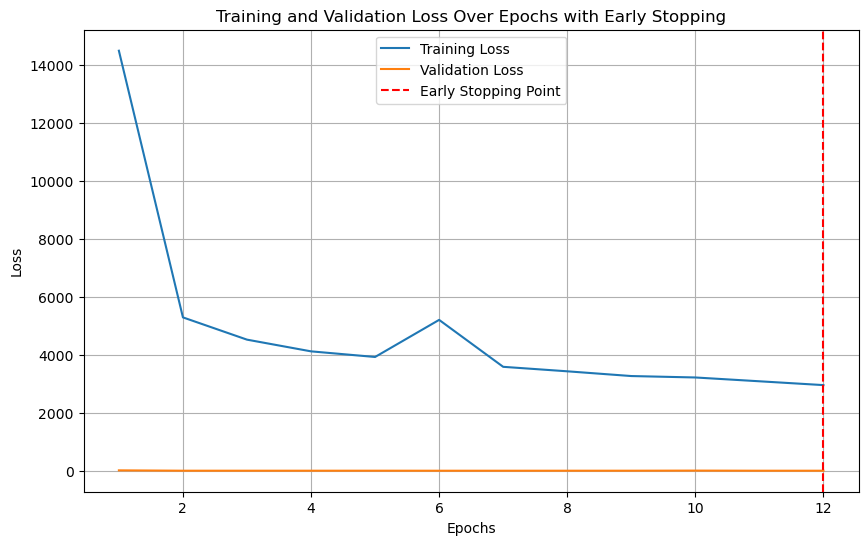

In [7]:
# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change in validation loss to qualify as an improvement
best_val_loss = float('inf')  # Initialize to a very large value
patience_counter = 0  # Counter for epochs without improvement

# Training the model with early stopping
train_losses = []
val_losses = []
early_stop = False

epochs = 50
batch_size = 32


# Create Dataset objects
train_dataset = TensorDataset(X_train, y_train)
validate_dataset = TensorDataset(X_validate, y_validate)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)



for epoch in range(epochs):
    if early_stop:
        print("Early stopping triggered!")
        break

    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    # Append losses for plotting
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    
    #print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Logging progress
    logging.basicConfig(level=logging.INFO)
    logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check for improvement
    # Check for improvement
    if best_val_loss - val_loss > min_delta:  # No need for .item()
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter
    else:
        patience_counter += 1  # Increment the counter
        if patience_counter >= patience:
            early_stop = True

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.axvline(len(train_losses), color='r', linestyle='--', label='Early Stopping Point')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
plt.legend()
plt.grid()
plt.savefig(f'plots/01_train_vall_loss/{file_name}.png')
plt.show()

# Test Simple Feed Forward NN

In [ ]:
# Create a Model Class that inherits nn.Module

class Model(nn.Module):
    # Input layer (344 ICU features) -->
    # Hidden Layer 1 (number of neurons) -->
    # Hidden Layer 2 (number of neurons) -->
    # Output (1 LOS)
    def __init__(self, input_dim, h1=256, h2=128, h3=64, h4=32, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.output = nn.Linear(h4, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.output(x)
        return x

In [ ]:
# Create an instance of a model
input_dim = X_train.shape[1] # retrive input features
model = Model(input_dim)

In [ ]:
# Set the criterion of model to measure the error

criterion = nn.MSELoss()

# Choose Optimizer, set learning rate and epochs (model.parameters are the NN layers)
optimizer =torch.optim.Adam(model.parameters(), lr=0.03)

In [ ]:
# model.parameters are the NN layers
display(model.parameters)
print("\n-------------------\n")
display(list(model.parameters()))
print("\n-------------------\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]}")  # Display first 2 values for brevity

In [ ]:
# Train model
epochs = 100
losses = []

for i in range(epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Ensure shapes match
    y_pred = y_pred.squeeze()  # Make y_pred a 1D tensor
    
    # Compute loss
    loss = criterion(y_pred, y_train)
    
    # Track losses
    losses.append(loss.item())
    
    # Print every 10 epochs
    if i % 10 == 0:
        print(f"Epoch: {i}, Loss: {loss.item()}")
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
plt.plot(range(epochs),losses)
plt.ylabel("loss/error")
plt.xlabel("Epoch")
plt.show()

# HyperOpt Feed Forward ANN
## Two hidden layers

In [ ]:
# Define the ANN model class
class ANNModel(nn.Module):
    def __init__(self, input_dim, layer1, layer2, dropout_rate):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, layer1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(layer1, layer2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(layer2, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # No activation in the output layer for regression
        return x

# Define the objective function
def objective(params):
    # Unpack parameters
    layer1 = int(params['layer1'])
    layer2 = int(params['layer2'])
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']

    # Initialize the model
    model = ANNModel(input_dim=X_train.shape[1], layer1=layer1, layer2=layer2, dropout_rate=dropout_rate)
    model.to(device)  # Move model to GPU if available

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 10  # Use a small number for quick evaluation
    batch_size = 32
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size].to(device)
            y_batch = y_train[i:i + batch_size].unsqueeze(1).to(device)

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_validate.to(device))
        val_loss = mean_squared_error(
            y_validate.cpu().numpy(),
            val_predictions.cpu().numpy()
        )

    # Return the loss as the optimization metric
    return {'loss': val_loss, 'status': STATUS_OK}

# Define the hyperparameter search space
param_space = {
    'layer1': hp.quniform('layer1', 64, 256, 32),
    'layer2': hp.quniform('layer2', 32, 128, 16),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', -4, -2),  # log scale for small LR
}

# Initialize Trials object
trials = Trials()

# Perform hyperparameter search
best = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=50,  # Number of iterations
    trials=trials
)

print("Best Hyperparameters:", best)

# Initialize the model with the best hyperparameters
best_model = ANNModel(
    input_dim=X_train.shape[1],
    layer1=int(best['layer1']),
    layer2=int(best['layer2']),
    dropout_rate=best['dropout_rate']
)
best_model.to(device)

# Train the best model on the entire training set
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best['learning_rate'])

In [ ]:
# Initialize the model with the best hyperparameters
best_model = ANNModel(
    input_dim=X_train.shape[1],
    layer1=int(best['layer1']),
    layer2=int(best['layer2']),
    dropout_rate=best['dropout_rate']
)
best_model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best['learning_rate'])

# Train the final model
epochs = 50
batch_size = 32
train_losses = []
val_losses = []

for epoch in range(epochs):
    best_model.train()
    epoch_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].unsqueeze(1).to(device)

        optimizer.zero_grad()
        predictions = best_model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    best_model.eval()
    with torch.no_grad():
        val_predictions = best_model(X_validate.to(device))
        val_loss = criterion(val_predictions, y_validate.unsqueeze(1).to(device)).item()

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Evaluate on test and external validation sets
best_model.eval()
with torch.no_grad():
    test_predictions = best_model(X_test.to(device))
    external_predictions = best_model(X_external.to(device))

    # Convert predictions back to CPU for evaluation
    test_predictions = test_predictions.cpu().numpy()
    external_predictions = external_predictions.cpu().numpy()

    # Calculate evaluation metrics
    mse_test = mean_squared_error(y_test.cpu(), test_predictions)
    mae_test = mean_absolute_error(y_test.cpu(), test_predictions)
    mse_external = mean_squared_error(y_external.cpu(), external_predictions)
    mae_external = mean_absolute_error(y_external.cpu(), external_predictions)

print(f"Test Set - MSE: {mse_test:.4f}, MAE: {mae_test:.4f}")
print(f"External Validation Set - MSE: {mse_external:.4f}, MAE: {mae_external:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


# Optuna HP

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 2, 3)  # Number of hidden layers
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)  # Neurons in hidden layers
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)  # Dropout probability
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)  # Learning rate
    batch_size = trial.suggest_int("batch_size", 16, 128, step=16)  # Batch size
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])  # Optimizer
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "Tanh"])  # Activation function

    # Define activation function
    activation = {
        "ReLU": nn.ReLU(),
        "LeakyReLU": nn.LeakyReLU(),
        "Tanh": nn.Tanh()
    }[activation_name]

    # Define the model
    class ANNModel(nn.Module):
        def __init__(self, input_dim):
            super(ANNModel, self).__init__()
            layers = []
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))

            for _ in range(n_layers - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(activation)
                layers.append(nn.Dropout(dropout_rate))

            layers.append(nn.Linear(hidden_size, 1))  # Output layer
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    # Prepare the model
    input_dim = X_train.shape[1]
    model = ANNModel(input_dim)

    # Select optimizer
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=learning_rate),
        "SGD": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
        "RMSprop": optim.RMSprop(model.parameters(), lr=learning_rate)
    }[optimizer_name]

    criterion = nn.MSELoss()

    # Prepare DataLoader
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Early stopping parameters
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    # Training loop
    model.train()
    for epoch in range(100):  # Max epochs
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_validate)
            val_loss = criterion(val_predictions, y_validate.view(-1, 1)).item()

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss

# Run the hyperparameter optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

In [ ]:
# Extract the best hyperparameters from the Optuna study
best_params = study.best_params
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["lr"]
batch_size = best_params["batch_size"]
optimizer_name = best_params["optimizer"]
activation_name = best_params["activation"]

# Define the activation function
activation = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(),
    "Tanh": nn.Tanh()
}[activation_name]

# Define the model using the best hyperparameters
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_size, 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Prepare the model
input_dim = X_train.shape[1]
model = ANNModel(input_dim)

# Select the optimizer based on the best parameters
optimizer = {
    "Adam": optim.Adam(model.parameters(), lr=learning_rate),
    "SGD": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
    "RMSprop": optim.RMSprop(model.parameters(), lr=learning_rate)
}[optimizer_name]

criterion = nn.MSELoss()

# Prepare DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Training loop
epochs = 100  # You can adjust this
patience = 5  # Early stopping patience
best_val_loss = float("inf")
patience_counter = 0

model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = criterion(val_predictions, y_validate.view(-1, 1)).item()

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(train_loader)}, Validation Loss: {val_loss}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optionally save the model if it's the best
        torch.save(model.state_dict(), 'best_ann_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print("Training complete.")

# Test & External Validation Evaluation

In [8]:
# Test and external validation
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).squeeze().numpy()
    y_external_pred = model(X_external).squeeze().numpy()

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)*100

external_mse = mean_squared_error(y_external, y_external_pred)
external_mae = mean_absolute_error(y_external, y_external_pred)
external_rmse = np.sqrt(external_mse)
external_r2 = r2_score(y_external, y_external_pred)*100

print(f"Test Set - MSE: {test_mse:.2f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")
print(f"External Validation - MSE: {external_mse:.2f}, MAE: {external_mae:.2f}, RMSE: {external_rmse:.2f}, R2: {external_r2:.2f}")

Test Set - MSE: 3.17, MAE: 1.27, RMSE: 1.78, R2: 37.21
External Validation - MSE: 5.42, MAE: 1.52, RMSE: 2.33, R2: -13.11


Test Set MSE: 3.1709
Test Set MAE: 1.2697
Test Set RMSE: 1.7807
Test Set R2: 37.2121
Test Set MSLE: 0.1547


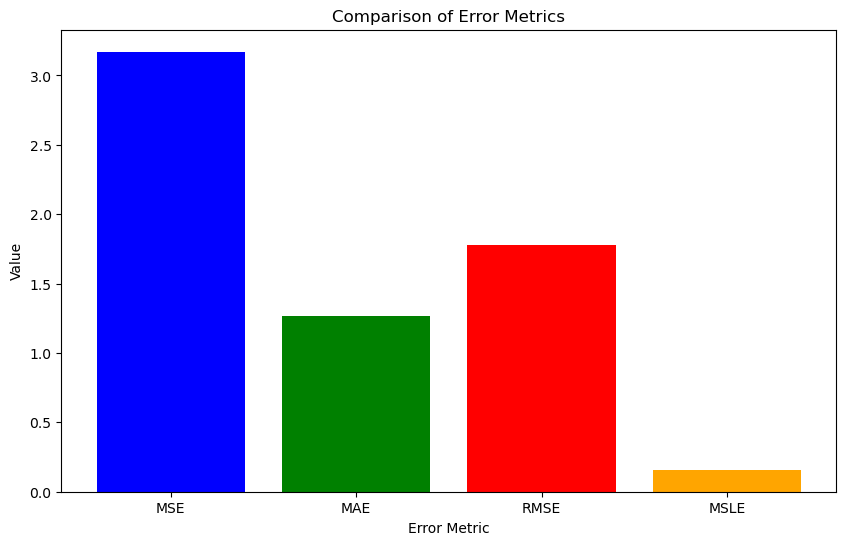

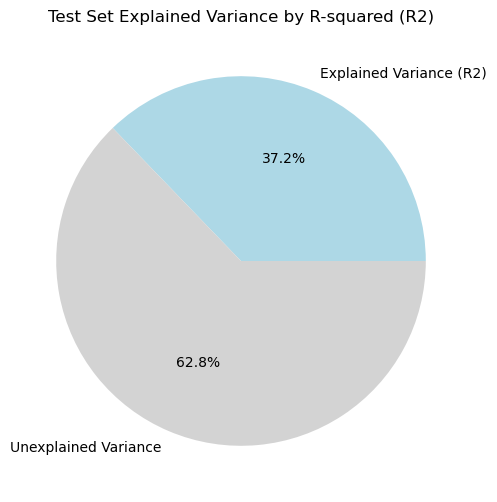

In [9]:
# Metrics calculation
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred) * 100

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set R2: {r2:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

# Try to calculate MSLE
try:
    msle = mean_squared_log_error(y_test, y_test_pred)
    print(f"Test Set MSLE: {msle:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')
plt.show()

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2 >= 0:
    plt.pie([r2, 100 - r2], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Test Set Explained Variance by R-squared (R2)')
plt.show()

External Validation Set MSE: 5.4186
External Validation Set MAE: 1.5186
External Validation Set RMSE: 2.3278
External Validation Set R2: -13.1051
Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.


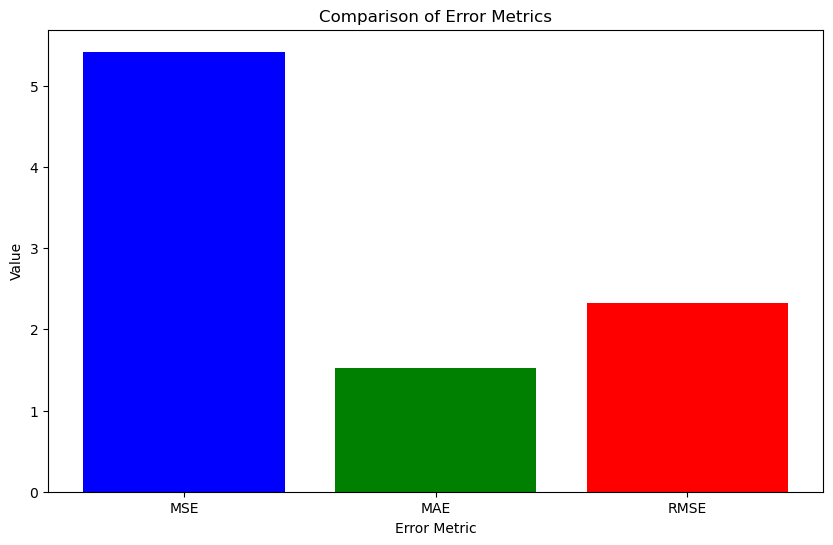

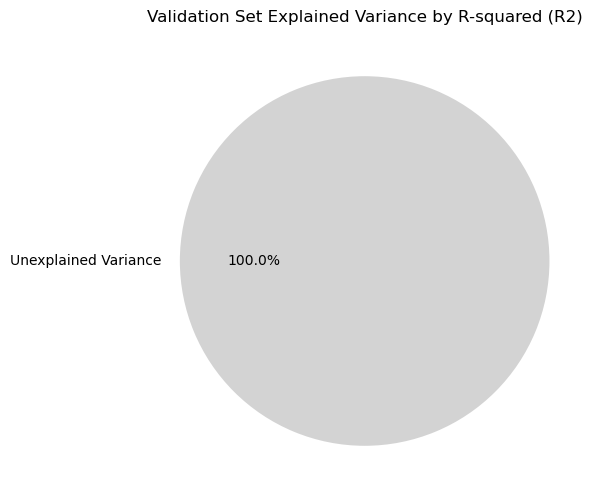

In [10]:
# Metrics for external validation set
mse_external = mean_squared_error(y_external, y_external_pred)
mae_external = mean_absolute_error(y_external, y_external_pred)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external, y_external_pred) * 100

print(f"External Validation Set MSE: {mse_external:.4f}")
print(f"External Validation Set MAE: {mae_external:.4f}")
print(f"External Validation Set RMSE: {rmse_external:.4f}")
print(f"External Validation Set R2: {r2_external:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse_external, mae_external, rmse_external]

# Try to calculate MSLE
try:
    msle_external = mean_squared_log_error(y_external, y_external_pred)
    print(f"External Validation Set MSLE: {msle_external:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle_external)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')
plt.show()

# Plotting R-squared (R2) for the external validation set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Validation Set Explained Variance by R-squared (R2)')
plt.show()

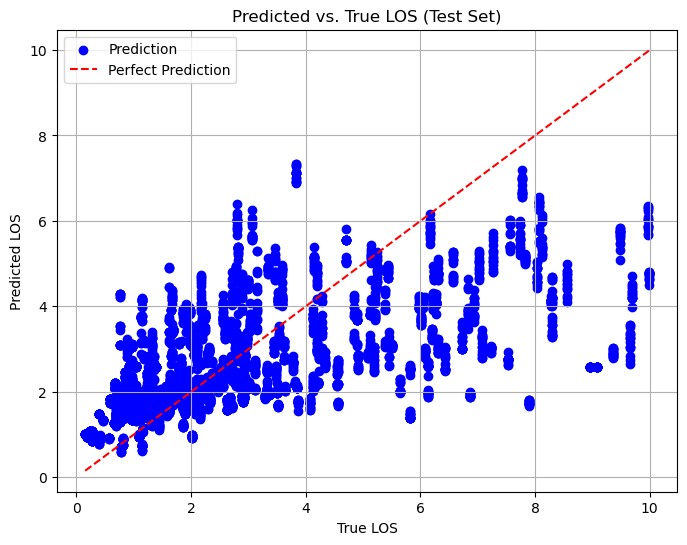

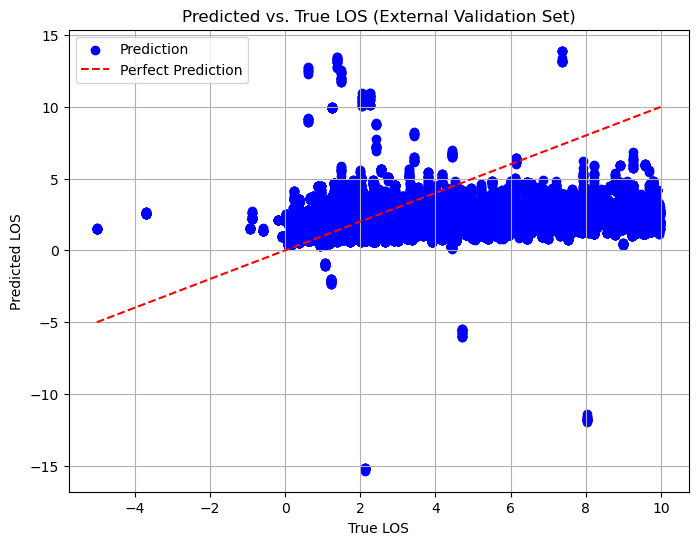

In [11]:
# Test Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Prediction')

# Line for Perfect Prediction
perfect_line = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (Test Set)')

# Save the plot as a PNG image
plt.savefig(f"plots/02_prediction_plot/02_true_vs_pred/{file_name}_test_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# External Validation Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_external, y_external_pred, color='blue', label='Prediction')

# Line for Perfect Prediction (y = x)
perfect_line_ext = np.linspace(y_external.min(), y_external.max(), 100)
plt.plot(perfect_line_ext, perfect_line_ext, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (External Validation Set)')

# Save the plot as a PNG image
plt.savefig(f"plots/02_prediction_plot/02_true_vs_pred/{file_name}_external_plot.png", dpi=300, bbox_inches='tight')
plt.show()

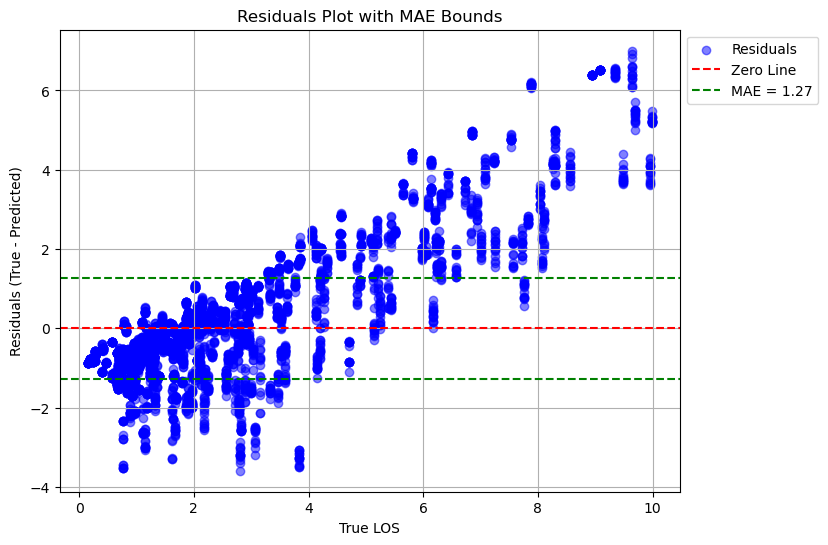

In [12]:
# Convert y_test to a 1D numpy array
y_test = y_test.numpy().flatten()


# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Line")
plt.axhline(y=mae, color='green', linestyle='--', label=f"MAE = {mae:.2f}")
plt.axhline(y=-mae, color='green', linestyle='--')
plt.xlabel('True LOS')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals Plot with MAE Bounds')
plt.grid(True)

# Place the legend outside of the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Save the plot as a PNG image
plt.savefig(f"plots/02_Prediction_Plot/01_residuals/{file_name}_residuals_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Save model

In [13]:
torch.save(model.state_dict(), f"models/{file_name}.pth")

# Load model

In [ ]:
# Define file
subfolder = "o01_feed_forward.pth"

# Reinitialize the model architecture
input_dim = X_test.shape[1]  # Ensure this matches the original input dimension
model = ANNModel(input_dim)

# Load the saved model state
model.load_state_dict(torch.load(f"models/{subfolder}"))
model.eval()  # Set the model to evaluation mode

"""
After that I must run the block with layers.
Be careful, the layers must be exaclty the same. 
"""

# SHAP

In [ ]:
def model_predict(X):
    model.eval()
    with torch.no_grad():
        tensor_X = torch.tensor(X, dtype=torch.float32)
        predictions = model(tensor_X).numpy()
    return predictions

In [ ]:
# Convert tensors to Pandas DataFrames
X_sample_df = pd.DataFrame(X_sample_np, columns=[f"Feature_{i}" for i in range(X_sample_np.shape[1])])
X_validate_df = pd.DataFrame(X_validate_np, columns=[f"Feature_{i}" for i in range(X_validate_np.shape[1])])

# Use KernelExplainer with Pandas DataFrame
explainer = shap.KernelExplainer(model_predict, X_sample_df)
shap_values = explainer.shap_values(X_validate_df)

# Summary plot
shap.summary_plot(shap_values, X_validate_df)